# Analitic model for single qubit

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import qutip as qu
import random
import pickle
from matplotlib import pyplot as plt
from tqdm import tqdm

df = pd.read_excel('09-1216A-A_DW_2000Q_6_annealing_schedule.xls', sheet_name=1)
nominal_temp_ghz = 13.5 / 47.9924341590788

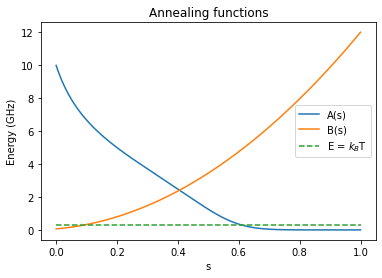

In [3]:
plt.figure()
plt.plot(df['s'], df['A(s) (GHz)'], label='A(s)')
plt.plot(df['s'], df['B(s) (GHz)'], label='B(s)')
plt.plot(np.linspace(0,1), nominal_temp_ghz * np.ones(50), linestyle='--', label='E = $k_B$T')

plt.title('Annealing functions')
plt.xlabel('s')
plt.ylabel('Energy (GHz)')
plt.legend()
plt.show()

## Last time results

In [4]:
biases_ex, spin_up_ex, dspin_up_ex = pickle.load(open("data/results.pickle", "rb"))

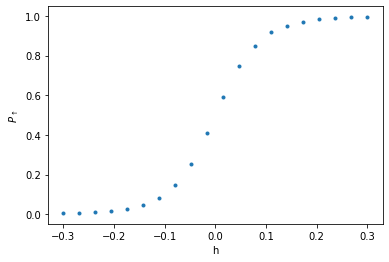

In [5]:
# grafico popolaz ground state vs h
plt.figure()
plt.errorbar(biases_ex, spin_up_ex, dspin_up_ex, marker='.', linestyle='')
plt.xlabel('h')
plt.ylabel(r'$P_\uparrow$')
plt.show()

## Solving Schroedinger eq: analitic solution at T=0

$$ \mathcal{H}_{\text{single qubit}} = - \frac{A(s)}{2} \hat{\sigma}_x + \frac{B(s)}{2} h \hat{\sigma}_z $$

Considering a linear ramping of s with time (from $t_i=0$ to $t_f = 20 \mu s$)

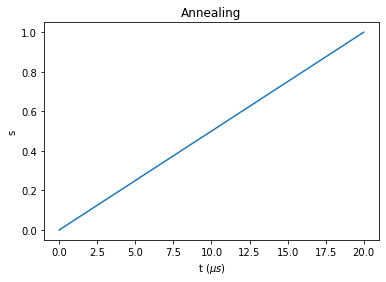

In [6]:
# linear foward anneal schedule
plt.figure()
plt.plot([0, 20], [0, 1])
plt.title('Annealing')
plt.xlabel('t ($\mu s$)')
plt.ylabel('s')
plt.show()

$$ i \hbar \frac{\partial}{\partial t} | \psi(t) \rangle = H(t) | \psi (t) \rangle $$

### Numerical integration

We can numerically solve schroedinger equation:
$$ | \psi(t+dt) \rangle = | \psi(t) \rangle - \frac{i}\hbar dt H(t) | \psi (t) \rangle $$

We need to choose a time interval $dt$ small such that $dt \times H(t) / \hbar << 1$.

Remebering that $H(t) / \hbar \sim 5 GHz$, we need $dt < 2 \times 10^{-10} s$

### QuTiP Toolkit

$$ \mathcal{H}_{\text{single qubit}} = - \frac{A(s)}{2} \hat{\sigma}_x + \frac{B(s)}{2} h \hat{\sigma}_z $$

In [6]:
# evolution with schroedinger equation
def schroed_evolution(t_f, h):
    
    # coefficients for linear annealing with time
    t = t_f * 1000 * df['s'].to_numpy()  # time (ns)

    S0 = qu.Cubic_Spline(t[0], t[-1], df['A(s) (GHz)'])
    S1 = qu.Cubic_Spline(t[0], t[-1], df['B(s) (GHz)'])
    
    # initial state of evolution
    psi0 = (qu.basis(2, 0) + qu.basis(2, 1)).unit()

    H0 = - qu.sigmax() / 2  # initial hamiltonian
    H1 = - h * qu.sigmaz() / 2  # final hamiltonian
    H = [[H0, S0], [H1, S1]]
    
    # actual evolution
    result = qu.sesolve(H, psi0, t, [qu.sigmaz()])
    
    return result

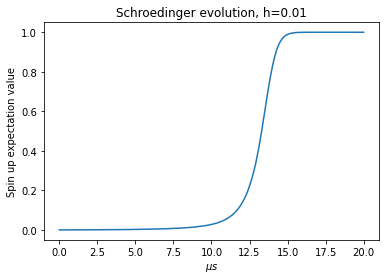

In [7]:
# plotting spin up expectation value during evolution
h = 0.01
result = schroed_evolution(20, h)

plt.figure()
plt.plot(result.times / 1000, result.expect[0])

plt.title(f'Schroedinger evolution, h={h}')
plt.xlabel('$\mu s$')
plt.ylabel('Spin up expectation value')
plt.show()

In [8]:
# perform schroedinger evolution for t_final = 20 mu s
t_final = 20  # mu s

biases_q = np.logspace(-4, -0.5, 8)
biases_q = sorted(np.concatenate((- biases_q, biases_q)))

# performing numerical calculation
p_up = [(schroed_evolution(t_final, h).expect[0][-1] + 1) / 2 for h in biases_q]

# save results on file
pickle.dump((biases_q, p_up), open(f"data/qu_schroedinger{str(t_final)}.pickle", "wb"))

100%|██████████| 16/16 [00:14<00:00,  1.13it/s]


In [9]:
# perform schroedinger evolution for t_final = 0.03 mu s
t_final = 0.03  # mu s

biases_q = np.linspace(-0.3, 0.3, 100)  # GHz

# performing numerical calculation
p_up = [(schroed_evolution(t_final, h).expect[0][-1] + 1) / 2 for h in biases_q]

# save results on file
pickle.dump((biases_q, p_up), open(f"data/qu_schroedinger{str(t_final)}.pickle", "wb"))

100%|██████████| 100/100 [00:09<00:00, 11.05it/s]


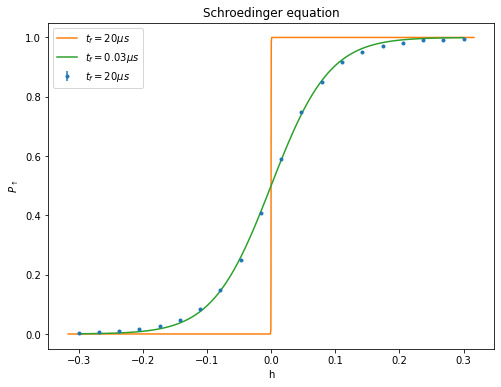

In [8]:
# opening saved data
biases_teo0, spin_up_teo0 = pickle.load(open("data/qu_schroedinger20.pickle", "rb"))
biases_teo1, spin_up_teo1 = pickle.load(open("data/qu_schroedinger0.03.pickle", "rb"))

# grafico popolaz ground state vs h, experiment and theory
plt.figure(figsize=(8, 6))
plt.errorbar(biases_ex, spin_up_ex, dspin_up_ex, marker='.', linestyle='', label='$t_f = 20 \mu s$')
plt.plot(biases_teo0, spin_up_teo0, label='$t_f = 20 \mu s$')
plt.plot(biases_teo1, spin_up_teo1, label='$t_f = 0.03 \mu s$')

plt.title('Schroedinger equation')
plt.xlabel('h')
plt.ylabel(r'$P_\uparrow$')
plt.legend()
plt.show()

## Lindbladian: considering thermal noise

$$ \dot{\rho} = -i \left[ \mathcal{H}, \rho \right] + \sum_k \left( L_k \rho L_k ^ \dagger - \frac{1}{2} L_k^\dagger L_k \rho - \frac{1}{2} \rho L_k^\dagger L_k \right) $$

With $ \{ L_k \}_{k=1}^{d^2-1} $ Linblad operators, traceless ortoghonal basis.

### Microscopic model

We can think at the qubit S, with hamiltonian $H_S$, coupled with the environment E with hamiltonian $H_E$, initialized in the Gibbs state $\rho_E=\exp(-\beta H_E) / \mathcal{Z}_E $, through the interaction hamiltonian $H_I$.

$$ H_{S} = - \frac{A(s)}{2} \hat{\sigma}_x + \frac{B(s)}{2} h \hat{\sigma}_z, \qquad H_E = \sum_{k=1}^\infty \omega_k b_k^\dagger b_k, \qquad
H_I = \sigma^z \otimes \left[ \sum_k g_k^i \left( b_k^\dagger + b_k \right) \right] $$

Where $b_k^\dagger$ and $b_k$ are the rising and lowering operator of the oscillator with frequency $\omega_k$, and $g_k$ is the coupling constant of such mode to the system S.

The Lindblad master equation takes the form:
$$ \dot{\rho}(t) = -i[H_s(t), \rho(t)] + \gamma(\omega_{ge}(t)) \left( L_{eg}(t) \rho(t) L_{eg} ^ \dagger(t) - \frac{1}{2} L_{eg}^\dagger (t) L_{eg} (t) \rho (t) - \frac{1}{2} \rho (t) L_{eg}^\dagger (t) L_{eg} (t) \right)  + \gamma(\omega_{eg}(t)) \left( L_{ge}(t) \rho(t) L_{ge} ^ \dagger(t) - \frac{1}{2} L_{ge}^\dagger (t) L_{ge} (t) \rho (t) - \frac{1}{2} \rho (t) L_{ge}^\dagger (t) L_{ge} (t) \right) $$
plus terms $\rightarrow 0$ in the adiabatic limit.

In this model, the Lindblad operator $L_k$ are $L_{eg}$ and $L_{ge}$ (respectively the raising and lowering operators), $L_{ab}=L_{a \leftarrow b}$:
$$\newcommand{\ket}[1]{|#1\rangle}
\newcommand{\bra}[1]{\langle#1|}$$
$$ L_{ab} = \ket{\epsilon_a(t)}\bra{\epsilon_a(t)} \sigma^z \ket{\epsilon_b(t)}\bra{\epsilon_b(t)} $$

The frequency $\omega_{ab}$ is defined:
$$\omega_{ba} = \epsilon_b - \epsilon_a $$

Given the environment state,

$$ \gamma(\omega) = \frac{2 \pi J(|\omega|)}{1-\exp(-\beta|\omega|)}g_{|\omega|}^2 \left( \Theta(\omega) + e^{-\beta |\omega|} \Theta(-\omega) \right) $$

$$ S_{ij}(\omega_{ba}(t)) = $$

Where $J(\omega)$ is an Ohmic bath spectral function with cutoff frequency $\omega_c$
$$ J(\omega)=\eta \omega \exp(-\omega / \omega_c), \qquad [\eta]=s^2 $$

### QuTiP Toolkit

In [137]:
# evolution with Lindblad
def lindblad_evolution(time, h, args):
    ''' Numerically solve me of Dwave single spin hamiltonian with bias h
        Return a qu.Result obj '''
    
    # hamiltonian coefficients for linear annealing with time
    t = 1000 * np.array(time)
    
    S0 = qu.Cubic_Spline(t[0], t[-1], df['A(s) (GHz)'])
    S1 = qu.Cubic_Spline(t[0], t[-1], df['B(s) (GHz)'])
    
    # hamiltonian
    H0 = - qu.sigmax() / 2  # initial hamiltonian
    H1 = - h * qu.sigmaz() / 2  # final hamiltonian
    H = [[H0, S0], [H1, S1]]
    
    # eigenvals and eigenstates
    def eigen(t):
        hamiltonian = S0(t) * H0 + S1(t) * H1
        eigenvals, eigenvect = hamiltonian.eigenstates()
        return eigenvals, eigenvect
    
    # lindblad coefficients and operators
    def L_ab(a, b):
        ''' prende 2 ket e restituisce |a><a| sigma_z |b><b| '''
        return a * a.dag() * qu.sigmaz() * b * b.dag()
    
    def gamma(omega, beta, g2, omega_c):
        ''' noti beta (1 / T), g (rate adimensionale), omega_c (cutoff)
            calcola il rate di passaggio da |e> a |g> (e viceversa) '''
        omega = abs(omega)
        
        return 2 * np.pi * omega * np.exp(- omega / omega_c) / (1 - np.exp(-beta*omega)) * g2

    # actual evolution
    def operator(t, type_):
        # return a Qobj operator
        eigenvals, eigenvect = eigen(t)
        
        if type_ == 'ge':
            return L_ab(eigenvect[0], eigenvect[1])
        if type_ == 'eg':
            return L_ab(eigenvect[1], eigenvect[0])
        raise IndexError

    def coefficient(t, type_):
        # return a C-number coefficient
        
        beta, g2, omega_c = args
        eigenvals, eigenvect = eigen(t)
        
        omega = eigenvals[1] - eigenvals[0]  # omega > 0
        assert(omega >= 0)
        
        gamm = gamma(omega, beta, g2, omega_c)  # omega > 0
        
        if type_ == 'ge':
            return gamm  # if omega > 0
        if type_ == 'eg':
            return gamm * np.exp(-beta * omega)  # if omega < 0
        raise IndexError
    
    # initial state of evolution
    psi0 = (qu.basis(2, 0) + qu.basis(2, 1)).unit()
    
    # building c_ops list
    c_ops = []
    n = 0
    
    def f(x, args):
        global n
        print(x, t[n])
        if x == t[n]:
            print('#############', n)
            n += 1
            return 1
        return 0
    
    for instant in t:
        c_ops.append([operator(instant, 'ge') * np.sqrt(coefficient(instant, 'eg')), f])
        c_ops.append([operator(instant, 'eg') * np.sqrt(coefficient(instant, 'ge')), lambda x, args: 1 if x == n else 0])
    
    result = qu.mesolve(H, psi0, t, c_ops, [qu.sigmaz(), qu.sigmax()])

    return result

In [139]:
time = np.linspace(0, 2, 10 + 1)  # mu s
h = 0.01
beta = 1 / nominal_temp_ghz
g2 = 1.2e-4 / (2 * np.pi) * 2
omega_c = 8 * np.pi

args = [beta, g2, omega_c]

n = 0
result = lindblad_evolution(time, h, args)

# save results on file
pickle.dump(result, open(f"data/qu_lindblad_expectation.pickle", "wb"))

0.0 0.0
############# 0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 200.0
0.0 20

0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.29304345903425155 200.0
0.2930434590

0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0
0.7219003847709488 200.0


1.1150192333629216 200.0
1.1150192333629216 200.0
1.1150192333629216 200.0
1.1150192333629216 200.0
1.1150192333629216 200.0
1.1150192333629216 200.0
1.1150192333629216 200.0
1.1150192333629216 200.0
1.1150192333629216 200.0
1.1150192333629216 200.0
1.1150192333629216 200.0
1.1150192333629216 200.0
1.1150192333629216 200.0
1.1150192333629216 200.0
1.1150192333629216 200.0
1.1150192333629216 200.0
1.1150192333629216 200.0
1.1150192333629216 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0
1.1507573105076465 200.0


1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0
1.5438761590996202 200.0


1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0
1.9727330848363187 200.0


2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.36585193342829 200.0
2.365851933

2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.758970782020261 200.0
2.75897078202026

3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0
3.1520896306122324 200.0


3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0
3.5452084792042036 200.0


3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.938327327796175 200.0
3.93832732779617

4.295708099243422 200.0
4.295708099243422 200.0
4.295708099243422 200.0
4.295708099243422 200.0
4.295708099243422 200.0
4.295708099243422 200.0
4.295708099243422 200.0
4.295708099243422 200.0
4.295708099243422 200.0
4.295708099243422 200.0
4.295708099243422 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.331446176388146 200.0
4.33144617638814

4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.688826947835393 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.724565024980118 200.0
4.72456502498011

5.081945796427364 200.0
5.081945796427364 200.0
5.081945796427364 200.0
5.081945796427364 200.0
5.081945796427364 200.0
5.081945796427364 200.0
5.081945796427364 200.0
5.081945796427364 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.117683873572089 200.0
5.11768387357208

5.51080272216406 200.0
5.51080272216406 200.0
5.51080272216406 200.0
5.51080272216406 200.0
5.51080272216406 200.0
5.51080272216406 200.0
5.51080272216406 200.0
5.51080272216406 200.0
5.51080272216406 200.0
5.51080272216406 200.0
5.51080272216406 200.0
5.51080272216406 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.546540799308785 200.0
5.54

5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.939659647900756 200.0
5.975397725045481 200.0
5.975397725045481 200.0
5.975397725045481 200.0
5.97539772504548

6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.368516573637452 200.0
6.36851657363745

6.761635422229423 200.0
6.761635422229423 200.0
6.761635422229423 200.0
6.761635422229423 200.0
6.761635422229423 200.0
6.761635422229423 200.0
6.761635422229423 200.0
6.761635422229423 200.0
6.761635422229423 200.0
6.761635422229423 200.0
6.761635422229423 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.797373499374148 200.0
6.79737349937414

7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.190492347966119 200.0
7.226230425110844 200.0
7.226230425110844 200.0
7.22623042511084

7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.58361119655809 200.0
7.619349273702815 200.0
7.619349273702815 200.0
7.619349273702815 200.0
7.619349273702815 200.0
7.619349273702815 200.0
7.619349273702815 200.0
7.619349273702815 200.0
7.619349273702815 200.0
7.619349273702815 200.0
7.619349273702815 200.0
7.619349273702815 200.0
7.619349273702815 200.0
7.619349273702815 200.0
7.619349273702815 200

8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.012468122294786 200.0
8.04820619943951 200.0
8.04820619943951 200.0
8.04820619943951 200.0
8.04820619943951 200.0
8.04820619943951 200.0
8.04820619943951 200.0
8.04820619943951 200.0
8.04820619943951 200.0
8.04820619943951 200.0
8.04820619943951 200.0
8.04820619943951 200.0
8.04820619943951 200.0
8.04820619943951 200.0
8.048

8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.477063125176207 200.0
8.47706312517620

8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.941658128057627 200.0
8.94165812805762

9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.334776976649598 200.0
9.33477697664959

9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.692157748096845 200.0
9.69215774809684

10.085276596688816 200.0
10.085276596688816 200.0
10.085276596688816 200.0
10.085276596688816 200.0
10.085276596688816 200.0
10.085276596688816 200.0
10.085276596688816 200.0
10.085276596688816 200.0
10.085276596688816 200.0
10.085276596688816 200.0
10.085276596688816 200.0
10.085276596688816 200.0
10.085276596688816 200.0
10.085276596688816 200.0
10.085276596688816 200.0
10.085276596688816 200.0
10.085276596688816 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0
10.12101467383354 200.0

10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0
10.549871599570237 200.0


10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0
10.978728525306932 200.0


11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0
11.407585451043628 200.0


11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0
11.872180453925049 200.0


12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0
12.301037379661745 200.0


12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.837239643187646 200.0
12.890868609963904 200.0
12.890868609963904 200.0
12.890868609963904 200.0
12.890868609963904 200.0
12.890868609963904 200.0
12.890868609963904 200.0
12.890868609963904 200.0
12.890868609963904 200.0


13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0
13.695303111607787 200.0


14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.49973761325167 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 200.0
14.553366580027928 2

15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0
15.304172114895552 200.0


16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.108606616539436 200.0
16.162235583315695 200.0
16.162235583315695 200.0
16.162235583315695 200.0
16.162235583315695 200.0
16.162235583315695 200.0
16.162235583315695 200.0
16.162235583315695 200.0
16.162235583315695 200.0
16.162235583315695 200.0
16.162235583315695 200.0
16.162235583315695 200.0
16.162235583315695 200.0
16.162235583315695 200.0
16.162235583315695 200.0
16.162235583315695 200.0
16.162235583315695 200.0
16.162235583315695 200.0


17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0
17.020299051735837 200.0


17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.82473355337972 200.0
17.878362520155978 200.0
17.878362520155978 200.0
17.878362520155978 200.0
17.878362520155978 200.0
17.878362520

18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0
18.521910121471084 200.0


19.16545772278619 200.0
19.16545772278619 200.0
19.16545772278619 200.0
19.16545772278619 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.21908668956245 200.0
19.2190866895624

20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.02352119120633 200.0
20.0235211912063

20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.774326726073955 200.0
20.827955692850214 200.0
20.827955692850214 200.0
20.827955692850214 200.0
20.827955692850214 200.0
20.827955692850214 200.0
20.827955692850214 200.0
20.827955692850214 200.0
20.827955692850214 200.0
20.827955692850214 200.0
20.827955692850214 200.0
20.827955692850214 200.0
20.827955692850214 200.0


21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0
21.632390194494096 200.0


22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.43682469613798 200.0
22.4368246961379

23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.29488816455812 200.0
23.2948881645581

24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.20658059975452 200.0
24.2065805997545

25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0
25.064644068174662 200.0


25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0
25.708191669489768 200.0


26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.45899720435739 200.0
26.4589972043573

27.102544805672498 200.0
27.102544805672498 200.0
27.102544805672498 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0
27.156173772448756 200.0


27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.85335034054012 200.0
27.8533503405401

28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0
28.711413808960263 200.0


29.30133244349911 200.0
29.30133244349911 200.0
29.30133244349911 200.0
29.30133244349911 200.0
29.30133244349911 200.0
29.30133244349911 200.0
29.30133244349911 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.35496141027537 200.0
29.3549614102753

30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0
30.105766945142992 200.0


30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.7493145464581 200.0
30.802943513234357 200.0
30.802943513234357 200.0
30.802943513234357 200.0
30.802943513234357 200.0
30.802943513234357 200.0
30.802943513234357 200.0
30.802943513234357 200.0
30.802943513234357 200.0
30.802943513234357 200.0
30.802943513234357 200.0
30.802943513234357 200.0
30.802943513234357 200.0
30.802943513234357 200.0
30.802943513234357 200.0
30.802

31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.55374904810198 200.0
31.5537490481019

32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.35818354974587 200.0
32.3581835497458

33.16261805138975 200.0
33.16261805138975 200.0
33.16261805138975 200.0
33.16261805138975 200.0
33.16261805138975 200.0
33.16261805138975 200.0
33.16261805138975 200.0
33.16261805138975 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.21624701816601 200.0
33.2162470181660

33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0
33.806165652704856 200.0


34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0
34.717858087901256 200.0


35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.52229258954514 200.0
35.5222925895451

36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.32672709118902 200.0
36.3267270911890

37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.18479055960916 200.0
37.1847905596091

37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0
37.935596094476786 200.0


38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.79365956289693 200.0
38.7936595628969

39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.59809406454081 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.65172303131707 200.0
39.6517230313170

40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.50978649973721 200.0
40.5097864997372

41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.36784996815735 200.0
41.3678499681573

42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.22591343657749 200.0
42.2259134365774

43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0
43.083976904997634 200.0


43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.942040373417775 200.0
43.995669340194034 200.0
43.995669340194034 200.0
43.995669340194034 200.0
43.995669340194034 200.0
43.995669340194034 200.0
43.995669340194034 200.0
43.995669340194034 200.0
43.995669340194034 200.0
43.995669340194034 200.0
43.995669340194034 200.0
43.995669340194034 200.0


44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0
44.853732808614176 200.0


45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.765425243810576 200.0
45.819054210586835 200.0
45.819054210586835 200.0
45.819054210586835 200.0
45.819054210586835 200.0
45.819054210586835 200.0
45.819054210586835 200.0
45.819054210586835 200.0
45.819054210586835 200.0
45.819054210586835 200.0
45.819054210586835 200.0
45.819054210586835 200.0
45.819054210586835 200.0


46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.62348871223072 200.0
46.6234887122307

Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

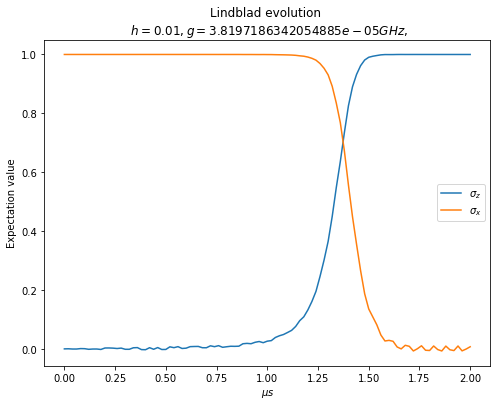

In [128]:
result = pickle.load(open(f"data/qu_lindblad_expectation.pickle", "rb"))

plt.figure(figsize=(8,6))
plt.plot(result.times / 1000, result.expect[0], label='$\sigma_z$')
plt.plot(result.times / 1000, result.expect[1], label='$\sigma_x$')

plt.title(f'Lindblad evolution \n $h={h}, g={g2} GHz, \beta={beta} GHz^{-1}$')
plt.xlabel('$\mu s$')
plt.ylabel('Expectation value')
plt.legend()
plt.show()

### Depreced code

In [49]:
def L_func(t, args):
    ''' This callback function is supposed to return the data of a superoperator, hence the L.data '''
    L = qu.liouvillian(H, [[operator(t, 'ge'), np.sqrt(coefficient(t, 'eg'))], [operator(t, 'eg'), np.sqrt(coefficient(t, 'ge'))]])
    return L.data

result = qu.mesolve(L_func, qu.ket2dm(psi0), t, [], [qu.sigmaz(), qu.sigmax()])

NameError: name 'psi0' is not defined

In [373]:
# evolution with schroedinger equation
def lindblad_evolution(t_f, h, num_time_divisions, gamma, beta, df):
     
    # hamiltonian coefficients for linear annealing with time
    t = np.linspace(0, 1000 * t_f, num_time_divisions)
    
    S0 = qu.Cubic_Spline(t[0], t[-1], df['A(s) (GHz)'])
    S1 = qu.Cubic_Spline(t[0], t[-1], df['B(s) (GHz)'])
    
    # hamiltonian
    H0 = - qu.sigmax() / 2  # initial hamiltonian
    H1 = - h * qu.sigmaz() / 2  # final hamiltonian
    H = [[H0, S0], [H1, S1]]
    
    # lindblad coefficients

    def gamma_plus(t, args):
        df = args['df']
        
        H0 = - qu.sigmax() / 2
        H1 = - args['h'] * qu.sigmaz() / 2
        S0 = qu.Cubic_Spline(args['ti'], args['tf'], df['A(s) (GHz)'])
        S1 = qu.Cubic_Spline(args['ti'], args['tf'], df['B(s) (GHz)'])
        
        ham_t = S0(t) * H0 + S1(t) * H1
        
        eigvals = ham_t.eigenenergies()
        energy_gap = eigvals[1] - eigvals[0]
        
        N = 1 / (np.exp(args['beta'] * energy_gap) - 1)
        
        return np.sqrt(args['gamma'] * N)
    
    def gamma_minus(t, args):
        df = args['df']
        
        H0 = - qu.sigmax() / 2
        H1 = - args['h'] * qu.sigmaz() / 2
        S0 = qu.Cubic_Spline(args['ti'], args['tf'], df['A(s) (GHz)'])
        S1 = qu.Cubic_Spline(args['ti'], args['tf'], df['B(s) (GHz)'])
        
        ham_t = S0(t) * H0 + S1(t) * H1
        
        eigvals = ham_t.eigenenergies()
        energy_gap = eigvals[1] - eigvals[0]
        
        N = 1 / (np.exp(args['beta'] * energy_gap) - 1)
        
        return np.sqrt(args['gamma'] * (N + 1))
    
    # lindblad operators
    c_ops = [[qu.sigmap(), gamma_plus] , [qu.sigmam(), gamma_minus]]
    args = {'gamma': gamma, 'beta': beta, 'h': h, 'df': df, 'ti': t[0], 'tf': t[-1]}
    
    # initial state of evolution
    psi0 = (qu.basis(2, 0) + qu.basis(2, 1)).unit()
    
    # actual evolution
    result = qu.mesolve(H, psi0, t, c_ops, [qu.sigmaz(), qu.sigmax()], args = args)
    
    return result

In [ ]:
# plotting sigma_z, sigma_z expectation value during evolution
num_time_divisions = 100
t_final = 2  # mu s
h = 0.3
gamma = 10  # kHz
beta = 1 / nominal_temp_ghz  # 1 / GHz

result = lindblad_evolution(t_final, h, num_time_divisions, gamma / 10 ** 6, beta, df)

# save results on file
pickle.dump(result, open(f"data/qu_lindblad_expectation.pickle", "wb"))

### Various h Lindblad evolution

In [355]:
# perform schroedinger evolution for t_final = 20 mu s
t_final = 1  # mu s
num_time_divisions = 50
gamma = 50  # kHz
beta = 1 / nominal_temp_ghz  # 1 / GHz

biases_q = np.linspace(-0.3, 0.3, 20)
biases_q = [-0.3, -0.1, -0.05, -0.025, -0.01, -0.005]
biases_q += [0.3, 0.1, 0.05, 0.025, 0.01, 0.005]
biases_q = np.array(sorted(biases_q))

# performing numerical calculation
p_up = [(lindblad_evolution(t_final, h, num_time_divisions, gamma / 10 ** 6, beta).expect[0][-1] + 1) / 2 for h in tqdm(biases_q)]

# save results on file
pickle.dump((biases_q, p_up), open(f"data/qu_lindblad_various_h.pickle", "wb"))

  0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

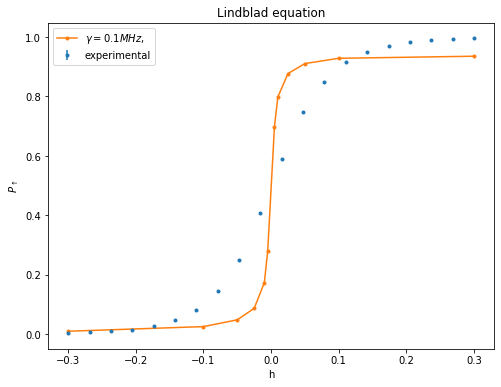

In [241]:
# opening saved data
biases_teo0, spin_up_teo0 = pickle.load(open(f"data/qu_lindblad_various_h.pickle", "rb"))

# grafico popolaz ground state vs h, experiment and theory
plt.figure(figsize=(8, 6))
plt.errorbar(biases_ex, spin_up_ex, dspin_up_ex, marker='.', linestyle='', label='experimental')
plt.plot(biases_teo0, spin_up_teo0,  marker='.', label=f'$\gamma={gamma} kHz, \beta={beta}$')

plt.title('Lindblad equation')
plt.xlabel('h')
plt.ylabel(r'$P_\uparrow$')
plt.legend()
plt.show()

## Resonance

In [349]:
# cerco quali device sono disponibili al momento
from dwave.cloud import Client

with Client.from_config() as client:
    for solver in client.get_solvers():
        print(solver.id)

Advantage_system1.1
hybrid_binary_quadratic_model_version2
hybrid_discrete_quadratic_model_version1
DW_2000Q_6


In [354]:
# scelgo il device e mi assicuro di poterci comunicare, stampo a schermo alcune caratteristiche
from dwave.system import DWaveSampler
import dwave.inspector

sampler = DWaveSampler(solver='DW_2000Q_6')

print(f'Maximum anneal-schedule points: {sampler.properties["max_anneal_schedule_points"]}')
print(f'Annealing time range: {sampler.properties["annealing_time_range"]} \u03BCs')
print(f'Maximum slope allowed on this solver is {1.0/sampler.properties["annealing_time_range"][0]}')

# sampler.properties

Maximum anneal-schedule points: 12
Annealing time range: [1, 2000] μs
Maximum slope allowed on this solver is 1.0


In [ ]:
# parametri
annealing_time = 2000
h1 = 0.01
# per h = 0.028, il gap di l'energia lungo z fra il ground e il primo ecc dovrebbe essere pari all'energia termica

trivial_reverse_schedule = [[0.0, 1.0], [annealing_time, 1.0]]
linear_offsets = {active_node: h1 * random.choice([-1, 1]) for active_node in sampler.nodelist}
initial_state = {active_node: np.sign(linear_offsets[active_node]) for active_node in linear_offsets}

In [ ]:
# RUN 'thermal' evolution of excited sigma_z eigenstate

sampler.validate_anneal_schedule(trivial_reverse_schedule)
# sampleset = sampler.sample_ising(linear_offsets, {}, num_reads=10, auto_scale=False, anneal_schedule=trivial_reverse_schedule, initial_state=initial_state, label=f'Trivial reverse annealing test h={h}')

# save data to file
# pickle.dump((linear_offsets, sampleset), open("resonance.pickle", "wb"))

In [ ]:
linear_offsets, sampleset = pickle.load(open("resonance.pickle", "rb"))
sampleset.aggregate().to_pandas_dataframe()

In [ ]:
# richiamo alcuni parametri della simulazione
num_qubits_per_run = len(sampleset.record["sample"][0])
final_B = df['B(s) (GHz)'].to_numpy()[-1]
anneling_times = np.array(trivial_reverse_schedule).T[0]

# definisco l'energia iniziale a cui ho inizializzato lo stato e l'energia finale dopo l'evol temporale (GHz)
initial_energy = final_B * h1
final_energy = final_B * np.sum(sampleset.record['energy'] * sampleset.record['num_occurrences']) / np.sum(sampleset.record['num_occurrences']) / num_qubits_per_run

print(f'Initial state energy for {num_qubits_per_run} qubits: {h1 * num_qubits_per_run:.2f}')

In [ ]:
# plotto l'evoluzione dello stato
plt.figure(figsize=(8, 6))
plt.scatter(anneling_times, np.array([initial_energy, final_energy]), label='My state')
plt.plot(anneling_times, np.array([-initial_energy, -initial_energy]), linestyle='--', color='C1', label='Ground State')
plt.plot(anneling_times, np.array([-initial_energy + nominal_temp_ghz, -initial_energy + nominal_temp_ghz]), linestyle='--', color='C2', label='Expected asintotic state with nominal termal fluctuations')

plt.title('Trivial reverse annealing')
plt.xlabel('time ($\mu s$)')
plt.ylabel(f'Energy of 1 qubit (GHz)')
plt.legend()
plt.show()

# Entanglement

$$ \mathcal{H}_{\text{2 qubits}} = - \frac{A(s)}{2} \left[ \hat{\sigma}_x^A \otimes \mathbb{I}^B + \mathbb{I}^A \otimes \hat{\sigma}_x^B \right] + \frac{B(s)}{2} \left[ h_A \hat{\sigma}_z^A \otimes \mathbb{I}^B + h_B \mathbb{I}^A \otimes \hat{\sigma}_z^B + J \hat{\sigma}_z^A \otimes \hat{\sigma}_z^B \right] $$

In [338]:
# Voglio calcolare l'entanglement dello stato al variare di s
J = 1
h = [0.2, 0]
t_f = 2
num_time_divisions = 1000

In [339]:
# hamiltonian coefficients for linear annealing with time
t = np.linspace(0, 1000 * t_f, num_time_divisions)

# annealing parameters
S0 = qu.Cubic_Spline(t[0], t[-1], df['A(s) (GHz)'])
S1 = qu.Cubic_Spline(t[0], t[-1], df['B(s) (GHz)'])

# initial hamiltonian
H0 = -qu.tensor(qu.sigmax(), qu.identity(2)) / 2   
H0 -= qu.tensor(qu.identity(2), qu.sigmax()) / 2

# final hamiltonian
H1 = J * qu.tensor(qu.sigmaz(), qu.sigmaz()) / 2
H1 += h[0] * qu.tensor(qu.sigmaz(), qu.identity(2)) / 2
H1 += h[1] * qu.tensor(qu.identity(2), qu.sigmaz()) / 2

H = [[H0, S0], [H1, S1]]

psi_1qu = (qu.basis(2, 0) + qu.basis(2, 1)).unit()
psi0 = qu.tensor(psi_1qu, psi_1qu)

Schroendinger evolution: $h$ greater that thermal noise to avoid simulation with me

Max concurrence: 0.5210859518021973
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.03970216+0.25825896j]
 [0.06387678+0.41309478j]
 [0.11994927+0.8056315j ]
 [0.04604417+0.30240454j]]


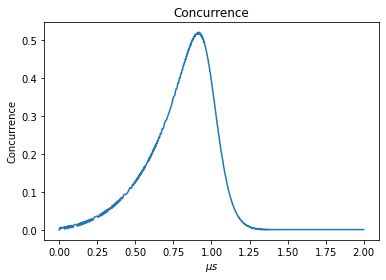

In [348]:
result = qu.sesolve(H, psi0, t, [])
entang = [qu.concurrence(result.states[i]) for i in range(len(result.times))]

max_entag_state = result.states[entang.index(max(entang))]

print('Max concurrence:', qu.concurrence(max_entag_state))
print(max_entag_state)

plt.figure()
plt.plot(result.times / 1000, entang)

plt.title(f'Concurrence')
plt.xlabel('$\mu s$')
plt.ylabel('Concurrence')
plt.show()

## Change h mid anneal

https://docs.dwavesys.com/docs/latest/c_solver_1.html#h-gain-schedule

$$ \mathcal{H}_{\text{ising}} = - \frac{A(s)}{2} \left( \sum_i \hat{\sigma}_x^{(i)} \right) + \frac{B(s)}{2} \left( g(t) \sum_i h_i \hat{\sigma}_z^{(i)} + \sum_{i>j} J_{i,j} \hat{\sigma}_z^{(i)} \hat{\sigma}_z^{(j)} \right) $$

- Controllo 'linearmente' attraverso 20 pti.
- Massimo range: [-5, 5]
- Altri vicoli.

# TODO:
- mini report venturelli
- same measure